In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [81]:
# Load data (deserialize)
with open('filename.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
nCol = data_dict["n"]
nRow = 1
nChannel = 1
tFinal = data_dict["tf"]
dx = data_dict["dx"]
L = data_dict["L"]

In [7]:
nSeq = 10

In [8]:
def split_sequence(data, nSeq):

    X, y = list(), list()
    nRow = data.shape[0]
    for i in range(nRow):
		# find the end of this pattern
        end_ix = i + nSeq
		# check if we are beyond the sequence
        if end_ix > nRow - 1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
X_, y = split_sequence(data, nSeq)
print(X_.shape)
print(y.shape)

(91, 10, 32)
(91, 32)


In [10]:
X_.shape

(91, 10, 32)

In [11]:
X = X_.reshape(X_.shape[0], nSeq, nRow, nCol, nChannel)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D

def createModel(type):
    inputLayer = Input(shape=(nSeq, nRow, nCol, nChannel))

    if (type == 'ConvLSTM'):
        layer = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputLayer)
        layer = Flatten()(layer)
    
    outputLayer = Dense(nCol)(layer)
    model = Model(inputs=inputLayer, outputs=outputLayer, name=type)

    return model

In [13]:
# Model building
tf.keras.backend.clear_session()
tf.random.set_seed(1)
# For somereason if I don't include this, I cannot execute this cell twice for LSTM and GRU
from tensorflow.keras.layers import LSTM, GRU

ConvLSTM = createModel('ConvLSTM')

ConvLSTM.summary()

Model: "ConvLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1, 32, 1)]    0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 1, 30, 64)         50176     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                61472     
Total params: 111,648
Trainable params: 111,648
Non-trainable params: 0
_________________________________________________________________


2022-04-30 06:53:45.320219: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-30 06:53:45.320934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-30 06:53:45.324104: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

def runModel(model, X, y, **kwargs):

    learning_rate = 0.001
    if 'learning_rate' in kwargs:
        learning_rate = kwargs['learning_rate']

    patience = 10
    if 'patience' in kwargs:
        patience = kwargs['patience']

    epochs=200
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=0)

    history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[earlyStoppingCallback ])

    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    plt.show()

2022-04-30 06:53:45.586740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-30 06:53:45.609075: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593215000 Hz


Epoch 1/2000
3/3 [==============================] - 2s 134ms/step - loss: 0.0577
Epoch 2/2000
3/3 [==============================] - 0s 150ms/step - loss: 0.0404
Epoch 3/2000
3/3 [==============================] - 0s 158ms/step - loss: 0.0172
Epoch 4/2000
3/3 [==============================] - 1s 188ms/step - loss: 0.0110
Epoch 5/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0039
Epoch 6/2000
3/3 [==============================] - 0s 137ms/step - loss: 0.0043
Epoch 7/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.0048
Epoch 8/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.0035
Epoch 9/2000
3/3 [==============================] - 0s 120ms/step - loss: 0.0028
Epoch 10/2000
3/3 [==============================] - 1s 206ms/step - loss: 0.0025
Epoch 11/2000
3/3 [==============================] - 0s 128ms/step - loss: 0.0019
Epoch 12/2000
3/3 [==============================] - 1s 333ms/step - loss: 0.0017
Epoch 13/2000
3/3 [======

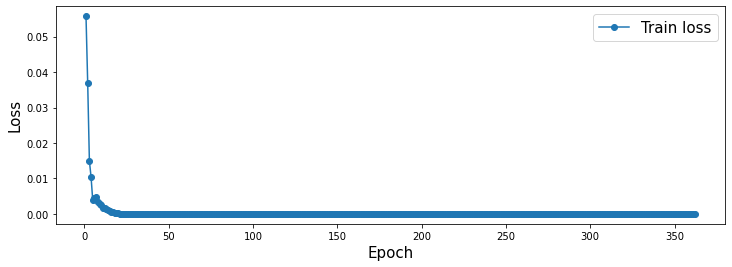

In [15]:
runModel(ConvLSTM, X, y, learning_rate=0.001, epochs=2000, patience=30)

In [16]:
def predictValue(model, X_):
    X = X_.reshape((1, nSeq, nRow, nCol, nChannel))
    yhat_ = model.predict(X, verbose=0)
    yhat = yhat_.flatten()
    return yhat

In [17]:
X_ = data[1:1+nSeq, :]
predictValue(ConvLSTM, X_)

array([-2.8437446e-04, -2.8515002e-04, -6.2476145e-05,  2.3775734e-04,
        5.0187670e-04,  1.4636917e-03,  4.2243805e-03,  1.1618746e-02,
        2.9847274e-02,  6.8423085e-02,  1.4043911e-01,  2.5556785e-01,
        4.0927154e-01,  5.7467848e-01,  7.1284211e-01,  7.9038310e-01,
        7.9020888e-01,  7.1270460e-01,  5.7463932e-01,  4.0903491e-01,
        2.5565407e-01,  1.4061025e-01,  6.8278670e-02,  2.9576054e-02,
        1.1712754e-02,  4.1453876e-03,  1.3262434e-03,  4.2070495e-04,
       -6.8355119e-05, -5.4755714e-05, -8.6951023e-04, -1.7730566e-04],
      dtype=float32)

array([-2.8437446e-04, -2.8515002e-04, -6.2476145e-05,  2.3775734e-04,
        5.0187670e-04,  1.4636917e-03,  4.2243805e-03,  1.1618746e-02,
        2.9847274e-02,  6.8423085e-02,  1.4043911e-01,  2.5556785e-01,
        4.0927154e-01,  5.7467848e-01,  7.1284211e-01,  7.9038310e-01,
        7.9020888e-01,  7.1270460e-01,  5.7463932e-01,  4.0903491e-01,
        2.5565407e-01,  1.4061025e-01,  6.8278670e-02,  2.9576054e-02,
        1.1712754e-02,  4.1453876e-03,  1.3262434e-03,  4.2070495e-04,
       -6.8355119e-05, -5.4755714e-05, -8.6951023e-04, -1.7730566e-04],
      dtype=float32)

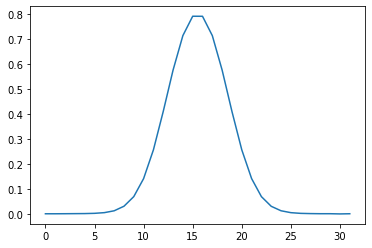

In [28]:
plt.plot(predictValue(ConvLSTM, X_))
predictValue(ConvLSTM, X_)

In [68]:
def calculateForecast(model, X_, nForecast):
    yA = list()
    
    for i in range(nSeq):
        yA.append(X_[i,:])
    
    for i in range(nForecast):
        XA = np.array(yA[-nSeq:])
        X = XA.reshape((1, nSeq, nRow, nCol, nChannel))
        yhat = predictValue(model, X)
        yA.append(yhat)

    return np.array(yA[nSeq:])

In [69]:
tFinal = data.shape[0]
nForecast = tFinal - nSeq
yPred = calculateForecast(ConvLSTM, data[:nSeq,:], nForecast)

In [70]:
yPred.shape



(91, 32)

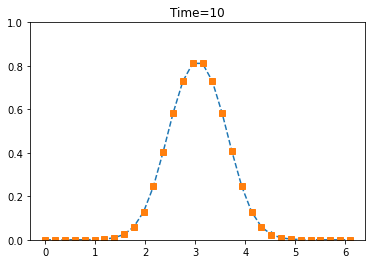

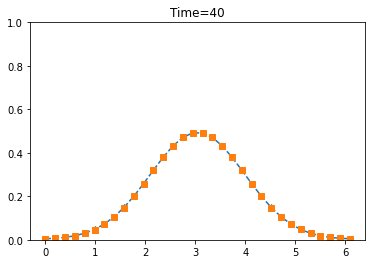

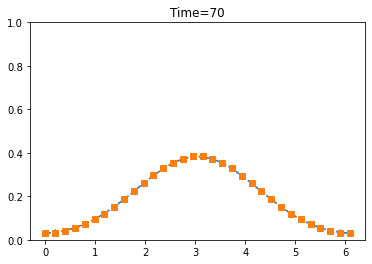

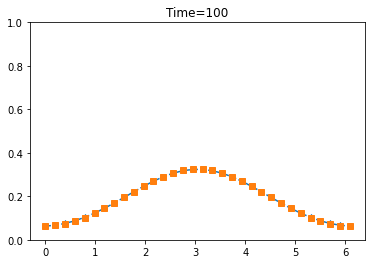

In [154]:
xp = np.arange(0,L,dx)
for t in range(0, tFinal, 30):
    fig, ax = plt.subplots()
    yPFC = y[t,:]
    yML = yPred[t,:]
    ax.plot(xp, yPFC, '*--')
    ax.plot(xp, yML,'s')
    ax.set_title(f'Time={t+nSeq}')
    ax.set_ylim([0,1])


Text(0.5, 0, 'Time')

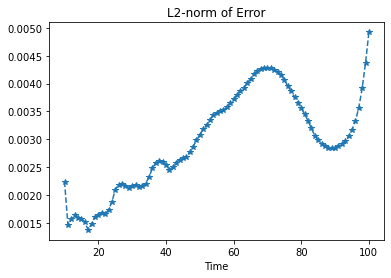

In [153]:
xp = np.arange(nSeq,tFinal+1)
errL2 = list()
for t in range(y.shape[0]):
    yPFC = y[t,:]
    yML = yPred[t,:]
    errL2.append(np.linalg.norm(yPFC-yML))
errL2 = np.array(errL2)

fig, ax = plt.subplots()
ax.plot(xp, errL2,'--*')
ax.set_title(r'L2-norm of Error')
ax.set_xlabel('Time')
